# Experiment mit dem Datensatz "Global Mean Sea level"

In [1]:
using Distributions, Compat, Plots, Random, CSV, DataFrames, GLM
upscale = 1.1
gr()
default(line = (:line, 0.5, 1, 2), size=(800*upscale,600*upscale))
#default(dpi = 100)
default(dpi = 500)

In diesem Abschnitt wird das Kalman Filter auf realen Daten angewendet. Dazu wird die Entwicklung der Meeresspiegel für Monaten genutzt. Die Daten stammen von [hier](https://datahub.io/core/sea-level-rise).

Wir lesen die Datei ein, entfernen fehlende Werte und erhalten:

In [2]:
data = CSV.File("./sea-level.csv") |> DataFrame # Read csv and create a dataframe
data[:GMSL] = convert(Array{Float64, 1}, data[:GMSL]) # Convert col to number
describe(data)

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Nothing,Union…,DataType
1,Time,1945.0,1880.04,1945.0,2009.96,,0,Float64
2,GMSL,-68.947,-182.9,-77.0,68.3,,,Float64
3,Uncertainty,11.4252,6.2,10.7,24.2,,0,Float64


Die Spalten sind wie folgt:

- Time: Tag genau Datum der Erfassung
- GMSL: Global Mean Sea Level, dt. globale durschnittliche Meeresspiegel. Einheit ist in `mm`.
- Uncertainity: Gibt an, wie sicher die Messung aus der Spalte `GMSL` ist.

In [3]:
first(data, 6)

,Time,GMSL,Uncertainty
,Float64⍰,Float64,Float64⍰
1,1880.04,-181.4,24.2
2,1880.13,-169.5,24.2
3,1880.21,-162.7,24.2
4,1880.29,-156.6,24.2
5,1880.38,-157.1,24.2
6,1880.46,-158.0,24.2


Die Entwicklung der Meeresspiegel ist folgendes:

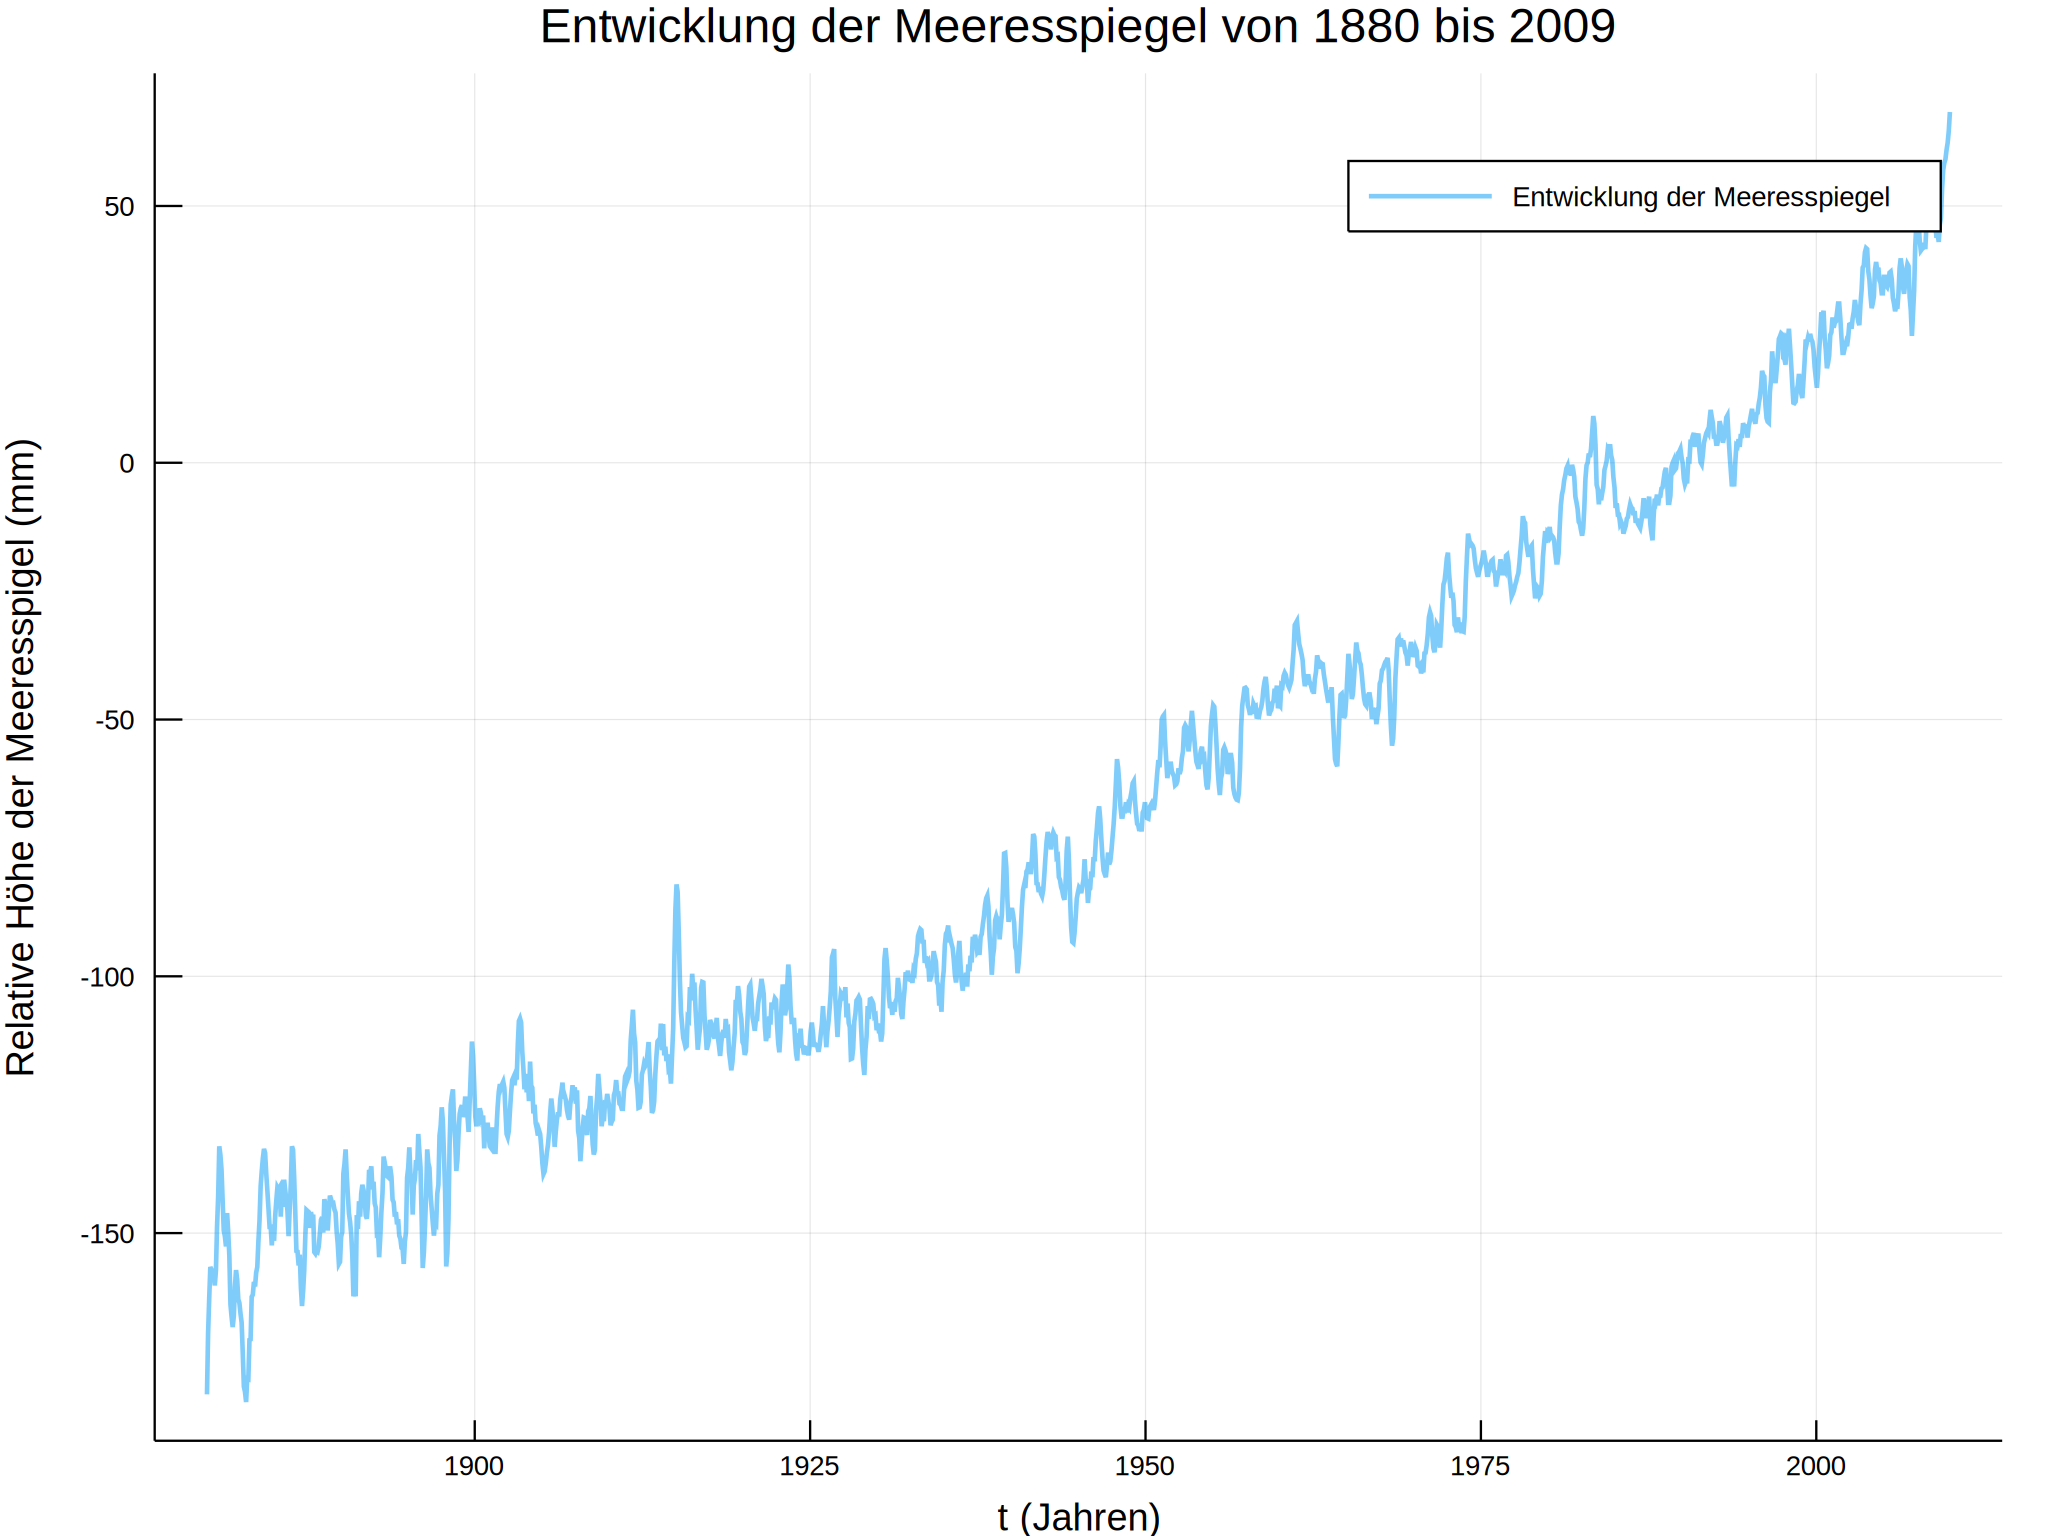

In [4]:
plot_gmsl = plot(data[:Time], data[:GMSL], 
    label = "Entwicklung der Meeresspiegel", 
    xlabel = "t (Jahren)", 
    ylabel = "Relative Höhe der Meeresspigel (mm)",
    title = "Entwicklung der Meeresspiegel von 1880 bis 2009",
)
png("gmsl.png")
plot_gmsl

In [5]:
linearmodel = fit(LinearModel, @formula(GMSL ~ Time), data)

StatsModels.DataFrameRegressionModel{LinearModel{LmResp{Array{Float64,1}},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: GMSL ~ 1 + Time

Coefficients:
             Estimate Std.Error  t value Pr(>|t|)
(Intercept)  -3060.07   12.8641 -237.877   <1e-99
Time          1.53785 0.0066127  232.561   <1e-99


In [6]:
@show coef(linearmodel)
@show stderror(linearmodel)
error = stderror(linearmodel)[1];

coef(linearmodel) = [-3060.07, 1.53785]
stderror(linearmodel) = [12.8641, 0.0066127]


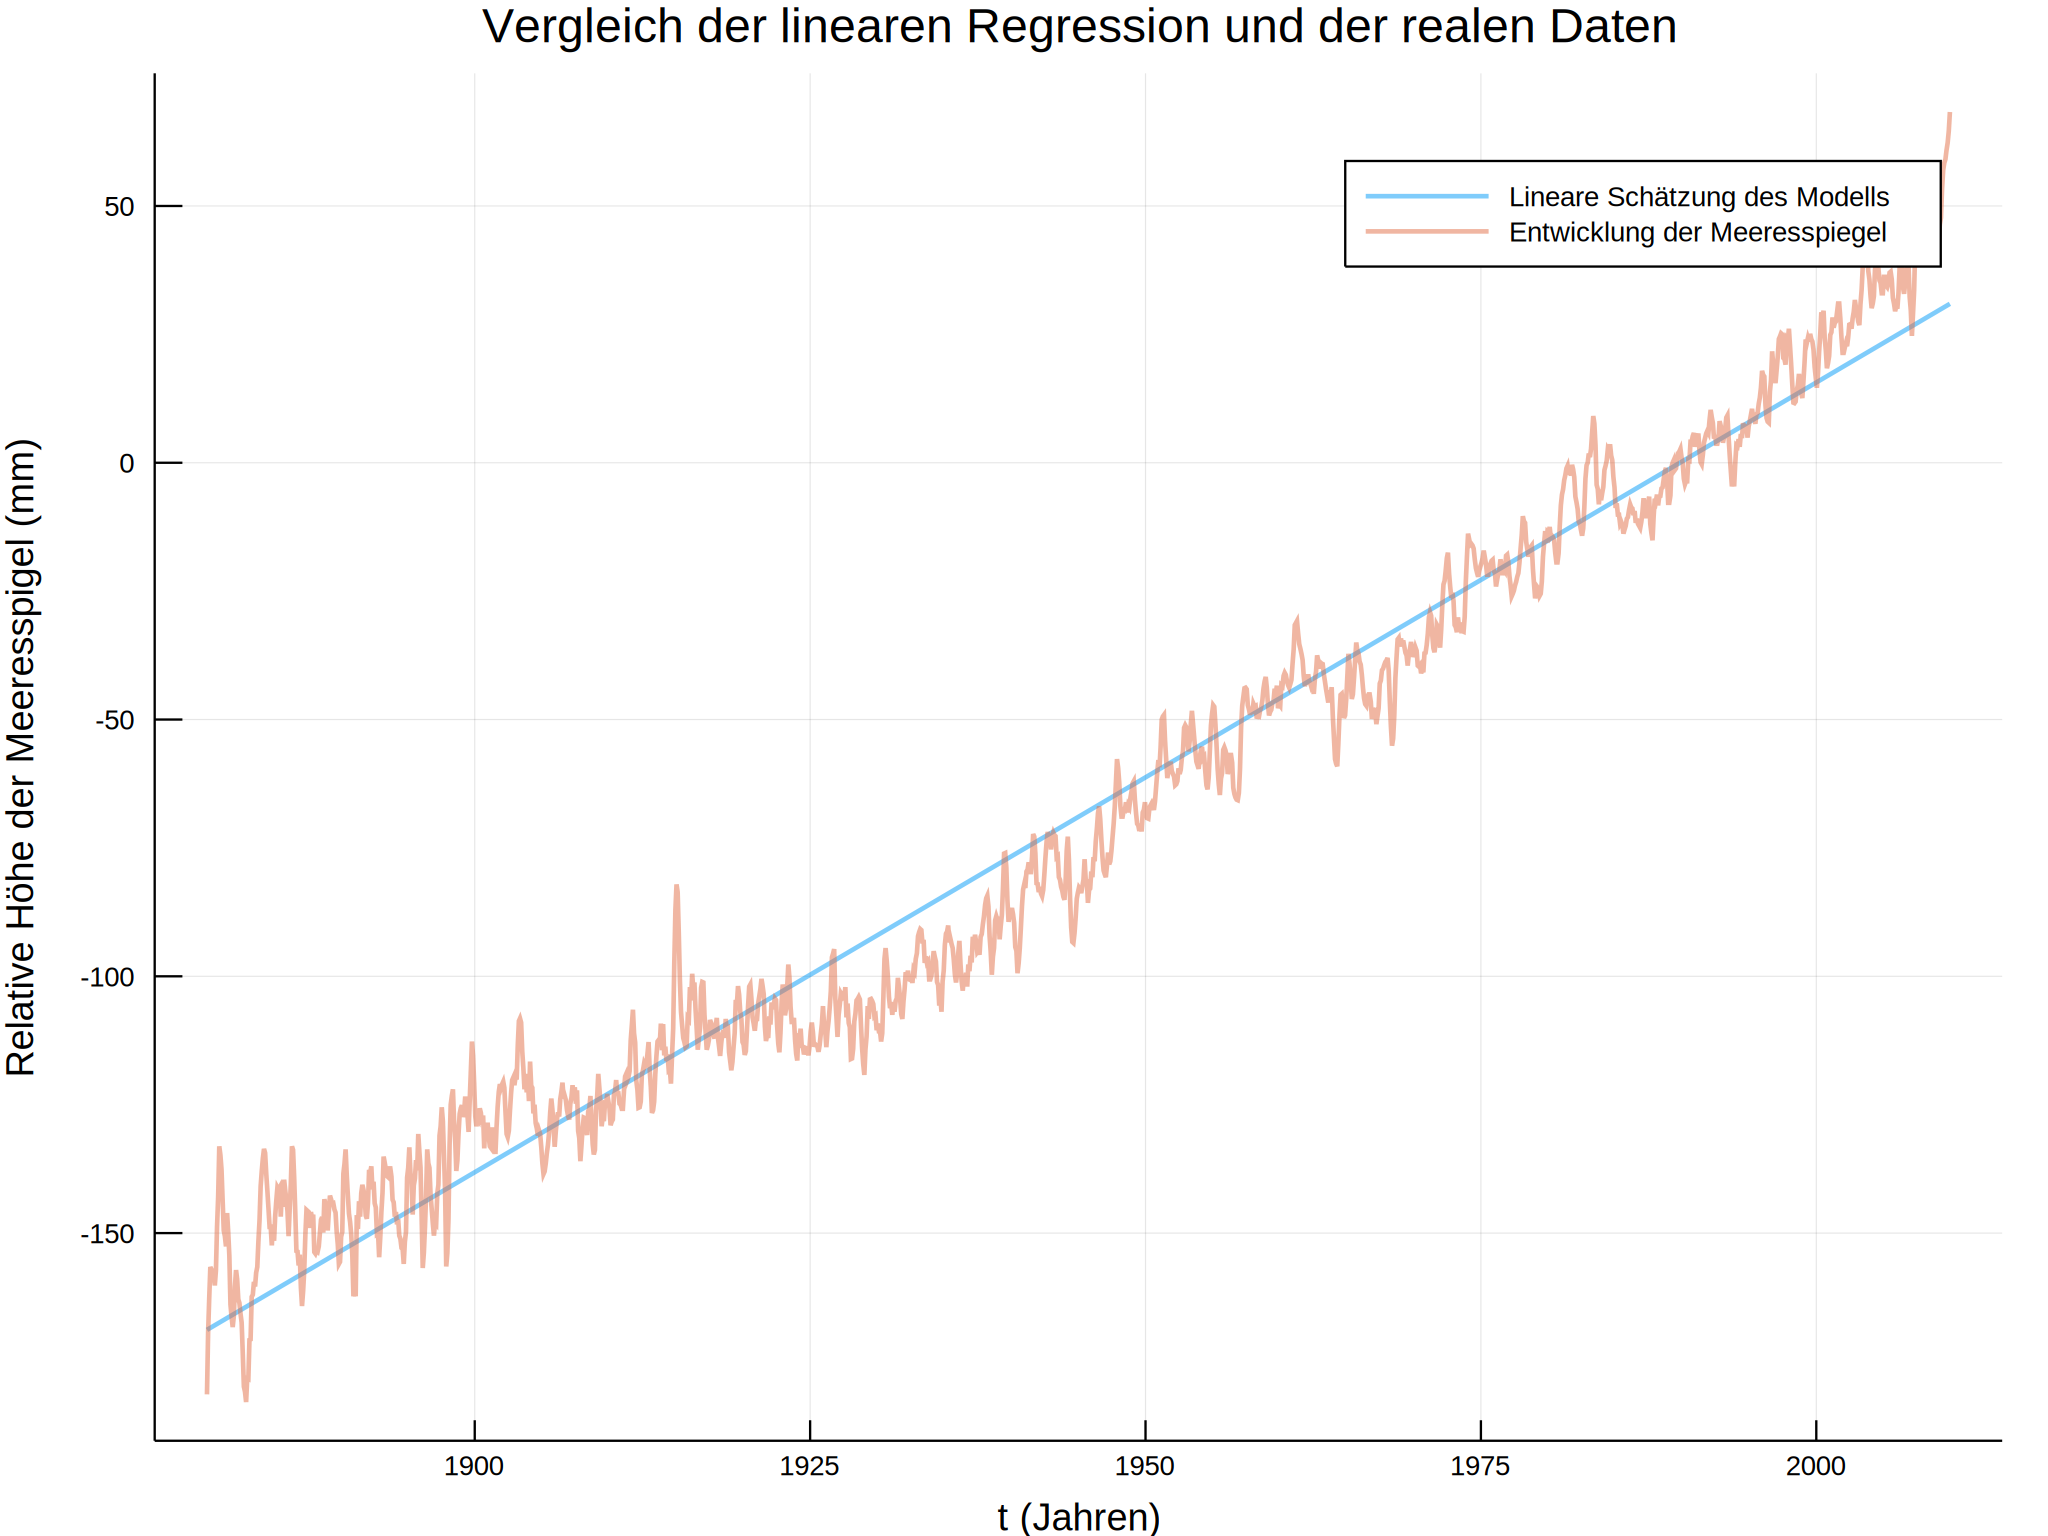

In [7]:
f(x) = coef(linearmodel)[2] * x + coef(linearmodel)[1]
plot_linear_regression = plot(xlabel = "t (Jahren)", ylabel = "Relative Höhe der Meeresspigel (mm)", title = "Vergleich der linearen Regression und der realen Daten")
plot!(data[:Time], f.(data[:Time]), label = "Lineare Schätzung des Modells")
plot!(data[:Time], data[:GMSL], label = "Entwicklung der Meeresspiegel")
png("linear_regression.png")
plot_linear_regression

In [8]:
include("../KalmanFilter.jl")
import .KalmanFilter

In [9]:
function shift(r)
   range(first(r) + 1, min(last(r) + 1, size(data)[1]))
end

shift (generic function with 1 method)

In [31]:
function experiment(A, Q, G, R)

    # A = 1 # Zustandsübergangsmatrix
    # Q = 0.001

    # G = 1 # Messabbildung Matrix
    # R = 0.6

    x̂_0 = data[1, :GMSL]
    # x̂_0 = f(1)
    Σ_0 = 1000

    model = KalmanFilter.Kalman(A, Q, G, R, x̂_0, Σ_0)

    data[:Fusioned] = map(x -> 0.0, data[:Time])
    data[:Predicted] = map(x -> 0.0, data[:Time])
    data[:Gain] = map(x -> 0.0, data[:Time])
    data[:Moving_Avg] = map(x -> 0.0, data[:Time])

    prev_prediction = -180

    current_window = 1:3
    for row in eachrow(data)
        y_cur = row[:GMSL]
        newInstance = KalmanFilter.next(model, y_cur)
        row[:Fusioned] = newInstance.fusioned
        row[:Predicted] = prev_prediction
        row[:Gain] = newInstance.gain
        row[:Moving_Avg] = mean(data[current_window, :GMSL])

        current_window = shift(current_window)
        prev_prediction = newInstance.predicted
        model = newInstance.model
    end

    plot_kalman = plot(
        xticks=(1800:10:2100), 
        xlabel = "t (Jahren)", 
        ylabel = "Meeresspigel (mm)",
        title = "Anwendung des Kalman Filter auf das Datensatz")
    plot!(data[:Time], data[:GMSL], label = "Global Mean Seal Level")
    plot!(data[:Time], data[:Predicted], label = "Vorhersage")
    plot!(data[:Time], data[:Fusioned], label = "Korrektur")
    plot!(data[:Time], data[:Moving_Avg], label = "Gleitender Mittelwert")

    plot_kalman_gain = plot(data[:Time], data[:Gain], 
        label = "Kalman Gewichtungsfaktor", 
        ylim = (0, 1), 
        linewidth = 2, 
        title = "Entwicklung des Kalman Gewichtungsfaktor",
        xticks = 1800:10:2000)

    plot_1910 = plot(xticks=(1800:10:2100), 
        xlabel = "t (Jahren)", 
        ylabel = "Meeresspigel (mm)", 
        title = "Detailansicht der Jahre 1900 bis 1920")
    plot!(data[240:480, :Time], data[240:480, :GMSL], label = "Global Mean Seal Level")
    plot!(data[240:480, :Time], data[240:480, :Predicted], label = "Vorhersage")
    plot!(data[240:480, :Time], data[240:480, :Fusioned], label = "Korrektur")
    plot!(data[240:480, :Time], data[240:480, :Moving_Avg], label = "Gleitender Mittelwert")

    name = "experiment-A=$(A),Q=$Q,G=$G,R=$R/"
    try
        mkdir(name)
    catch
    end
    png(plot_kalman, "$name/gmsl-kalman.png")
    png(plot_1910, "$name/detailansicht-1900-1920-kalman.png")
    png(plot_kalman_gain, "$name/kalman-gain.png")

    plot(layout = @layout [plot_kalman; plot_kalman_gain plot_1910])
    plot!(plot_kalman, subplot = 1)
    plot!(plot_1910)

    plot(plot_kalman, plot_1910, plot_kalman_gain,
        size = (upscale * 1000, upscale * 1200), 
        layout = (@layout [a{0.4h}; b{0.4h} ; c]),
        legend = :topleft)
    png("$name/kombiniert.png")
end

experiment (generic function with 1 method)

In [32]:
experiment(1, 0.001, 1, 0.6);

In [33]:
experiment(1, 0.5, 1, 0.01);

In [34]:
experiment(1, 0.1, 0.6, 0.05);

In [35]:
experiment(0.5, 0.1, 1, 0.6);

In [36]:
experiment(0.5, 0.1, 1, 0.001);

In [37]:
experiment(1.2, 0.001, 1, 0.6);